In [1]:
import torchvision
import torch
from transformers import ViTImageProcessor, ViTForImageClassification ,ViTFeatureExtractor
from PIL import Image
from torchvision import transforms

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point , Polygon
from sklearn.cluster import DBSCAN
import re
import requests
import os
import matplotlib.pyplot as plt
import random

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
import torchvision
from transformers import ViTImageProcessor, ViTForImageClassification ,ViTFeatureExtractor
from PIL import Image,ImageOps
from torchvision import transforms
from salem import  DataLevels, GoogleVisibleMap, Map

## Prepare to embed with  openai/clip-vit-large-patch14

In [3]:
from sklearn.metrics.pairwise import cosine_similarity

# Load the ViT model and feature extractor
model_name = "openai/clip-vit-large-patch14"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)

# Define a function to preprocess and encode an image
def encode_image(image):
    
    # Pass the PIL.Image.Image object to the feature extractor
    inputs = feature_extractor(images=image, return_tensors="pt")
    # Use the model to encode the input features and get the logits
    with torch.no_grad():
        outputs = model(**inputs)
        features = outputs.logits
    return features


C:\Users\kittisak\anaconda3\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
You are using a model of type clip to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing ViTForImageClassification: ['text_model.encoder.layers.2.self_attn.k_proj.bias', 'text_model.encoder.layers.8.layer_norm1.weight', 'text_model.encoder.layers.7.self_attn.q_proj.bias', 'vision_model.encoder.layers.9.self_attn.out_proj.weight', 'text_model.encoder.layers.3.self_attn.v_proj.weight', 'vision_model.encoder.layers.18.self_attn.q_proj.weight', 'text_model.encoder.layers.6.layer_norm1.weight', 'vision_model.encoder.layers.12.mlp.fc1.weight', 'text_model.encoder.layers.10.s

Some weights of ViTForImageClassification were not initialized from the model checkpoint at openai/clip-vit-large-patch14 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
def get_img_salem(location ,r=0.0003,maptype='satellite',crop = 0):
    '''This function return image in PIL format
    Bring API from Salem module
    location = [latitude,longtitude]
    size = image size
    r = width and hieght of picture if r less than 0.0004 , no different
    '''
    
    pic_lat,pic_long = location
    pic_map = GoogleVisibleMap(x=[pic_long-r, pic_long+r], y=[pic_lat-r, pic_lat + r], maptype=maptype)
    
    # Create a salem image data
    img = pic_map.get_vardata()

    #convert to PIL and transform image 

    im = Image.fromarray((img * 256).astype(np.uint8))
    im = im.convert("RGB")
    
    border = (crop, crop, crop, crop) # left, top, right, bottom
    im = ImageOps.crop(im, border)
    return im


In [5]:
# define lat long and searching area
lat , long = [13.898331,100.709872]
# area about 2.2 km diameter from lat , long
search_area = Point(long,lat).buffer(0.006,cap_style = 3)

# import data

In [6]:
mooban_df = pd.read_csv(r'..\..\data\mooban_opendata.csv')

In [7]:
#Focus on กรุงเทพมหานคร

mooban_df = mooban_df[mooban_df['PROV_NAMT'] == 'กรุงเทพมหานคร']

# create geodataframe to use geospartial data properties


mooban_gdf = gpd.GeoDataFrame(mooban_df , geometry = gpd.points_from_xy(mooban_df.LONG, mooban_df.LAT),crs = 'EPSG:4326')

# select the maximum value count amp to test

mooban_gdf[mooban_gdf['AMP_NAMT'] == 'คลองสามวา']


#query data only in search area

mooban_gdf_in_area = mooban_gdf[mooban_gdf.geometry.within(search_area)]

In [8]:
cluster_df = pd.read_csv(r'..\..\data\cluster_point.csv').drop('Unnamed: 0',axis = 1)
cluster_polygon_gdf = gpd.read_file(r'..\..\data\cluster_polygon\custer_polygon.shp')
cluster_polygon_gdf['centroid'] = cluster_polygon_gdf['geometry'].centroid

In [9]:
cluster_polygon_gdf 

cluster                                           geometry  \
0       1.0  POLYGON ((13.902 100.705, 13.899 100.706, 13.8...   
1       2.0  POLYGON ((13.902 100.705, 13.902 100.705, 13.8...   
2       6.0  POLYGON ((13.901 100.707, 13.901 100.707, 13.9...   
3       8.0  POLYGON ((13.901 100.707, 13.900 100.707, 13.9...   
4       9.0  POLYGON ((13.901 100.707, 13.902 100.710, 13.9...   
5      10.0  POLYGON ((13.903 100.706, 13.903 100.706, 13.9...   
6      11.0  POLYGON ((13.904 100.708, 13.904 100.708, 13.9...   
7      12.0  POLYGON ((13.902 100.707, 13.902 100.707, 13.9...   
8      14.0  POLYGON ((13.901 100.711, 13.901 100.711, 13.8...   
9      15.0  POLYGON ((13.901 100.712, 13.900 100.712, 13.9...   
10     16.0  POLYGON ((13.898 100.709, 13.897 100.709, 13.8...   
11     17.0  POLYGON ((13.901 100.712, 13.895 100.713, 13.8...   
12     18.0  POLYGON ((13.902 100.710, 13.902 100.710, 13.9...   
13     19.0  POLYGON ((13.901 100.710, 13.899 100.710, 13.8...   
14     20.0  POLYGON ((13.901 100.713, 13.901 100.713, 13.8...   
15     21.0  POLYGON ((13.901 100.715, 13.901 100.715, 13.8...   
16     28.0  POLYGON ((13.896 100.712, 13.896 100.713, 13.8...   

                  centroid  
0   POINT (13.898 100.706)  
1   POINT (13.898 100.706)  
2   POINT (13.902 100.711)  
3   POINT (13.901 100.708)  
4   POINT (13.902 100.709)  
5   POINT (13.904 100.708)  
6   POINT (13.904 100.710)  
7   POINT (13.903 100.712)  
8   POINT (13.898 100.712)  
9   POINT (13.900 100.712)  
10  POINT (13.898 100.709)  
11  POINT (13.897 100.713)  
12  POINT (13.902 100.712)  
13  POINT (13.897 100.710)  
14  POINT (13.899 100.713)  
15  POINT (13.898 100.715)  
16  POINT (13.897 100.712)

In [10]:
cluster_list = np.unique(cluster_df['cluster'].values)

## Embedding Image in cluster

In [11]:
from tqdm import tqdm

In [12]:
embedding_output = {'cluster':[]
                ,'embbeding_vector':[]}
#embedding and weigth in same cluseter
for cluster in cluster_list:
    #loop depend on cluster of data
    
    focus_df = cluster_df[cluster_df['cluster'] == cluster]
    #random only 50% of image to encode faster
    index_random = random.sample(range(0, len(focus_df)), int(len(focus_df)*0.5))
    #define to collect embbeding feature
    cluster_features = 0
    # embbeding image in cluster and weigth it
    for i in tqdm(range(len(index_random))):
        
        pic = get_img_salem([focus_df.iloc[i]['ltt'],focus_df.iloc[i]['lgt']],crop = 40)
        image_features = encode_image(pic)
        cluster_features += image_features
    
    #mean the image_features
    cluster_features = cluster_features/len(index_random)
    
    #add to embedding output dict
    embedding_output['cluster'].append(cluster)
    embedding_output['embbeding_vector'].append(cluster_features)
        
    

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:07<00:00,  2.38it/s]


In [13]:
embbeding_df = pd.DataFrame(embedding_output)
embbeding_df = cluster_polygon_gdf.merge(embbeding_df, how = 'inner')
embbeding_df

cluster                                           geometry  \
0       1.0  POLYGON ((13.902 100.705, 13.899 100.706, 13.8...   
1       2.0  POLYGON ((13.902 100.705, 13.902 100.705, 13.8...   
2       6.0  POLYGON ((13.901 100.707, 13.901 100.707, 13.9...   
3       8.0  POLYGON ((13.901 100.707, 13.900 100.707, 13.9...   
4       9.0  POLYGON ((13.901 100.707, 13.902 100.710, 13.9...   
5      10.0  POLYGON ((13.903 100.706, 13.903 100.706, 13.9...   
6      11.0  POLYGON ((13.904 100.708, 13.904 100.708, 13.9...   
7      12.0  POLYGON ((13.902 100.707, 13.902 100.707, 13.9...   
8      14.0  POLYGON ((13.901 100.711, 13.901 100.711, 13.8...   
9      15.0  POLYGON ((13.901 100.712, 13.900 100.712, 13.9...   
10     16.0  POLYGON ((13.898 100.709, 13.897 100.709, 13.8...   
11     17.0  POLYGON ((13.901 100.712, 13.895 100.713, 13.8...   
12     18.0  POLYGON ((13.902 100.710, 13.902 100.710, 13.9...   
13     19.0  POLYGON ((13.901 100.710, 13.899 100.710, 13.8...   
14     20.0  POLYGON ((13.901 100.713, 13.901 100.713, 13.8...   
15     21.0  POLYGON ((13.901 100.715, 13.901 100.715, 13.8...   
16     28.0  POLYGON ((13.896 100.712, 13.896 100.713, 13.8...   

                  centroid                     embbeding_vector  
0   POINT (13.898 100.706)  [[tensor(-0.9359), tensor(0.3573)]]  
1   POINT (13.898 100.706)  [[tensor(-0.8973), tensor(0.4002)]]  
2   POINT (13.902 100.711)  [[tensor(-0.5890), tensor(0.2374)]]  
3   POINT (13.901 100.708)  [[tensor(-0.8681), tensor(0.4139)]]  
4   POINT (13.902 100.709)  [[tensor(-0.3100), tensor(0.2604)]]  
5   POINT (13.904 100.708)  [[tensor(-0.7996), tensor(0.3820)]]  
6   POINT (13.904 100.710)  [[tensor(-0.7701), tensor(0.5295)]]  
7   POINT (13.903 100.712)  [[tensor(-0.4446), tensor(0.2802)]]  
8   POINT (13.898 100.712)  [[tensor(-0.9497), tensor(0.4100)]]  
9   POINT (13.900 100.712)  [[tensor(-1.0476), tensor(0.2165)]]  
10  POINT (13.898 100.709)  [[tensor(-0.8434), tensor(0.4478)]]  
11  POINT (13.897 100.713)  [[tensor(-0.8247), tensor(0.5009)]]  
12  POINT (13.902 100.712)  [[tensor(-0.8910), tensor(0.3885)]]  
13  POINT (13.897 100.710)  [[tensor(-0.9326), tensor(0.3487)]]  
14  POINT (13.899 100.713)  [[tensor(-0.8049), tensor(0.5326)]]  
15  POINT (13.898 100.715)  [[tensor(-0.7984), tensor(0.5570)]]  
16  POINT (13.897 100.712)  [[tensor(-0.8615), tensor(0.5079)]]

In [14]:
embbeding_df['cluster'].values

array([ 1.,  2.,  6.,  8.,  9., 10., 11., 12., 14., 15., 16., 17., 18.,
       19., 20., 21., 28.])

In [15]:
embbeding_df.iloc[0]['centroid'].y

100.70593215034332

In [16]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
import haversine as hs
from haversine import Unit

data_point = [[embbeding_df.iloc[i]['centroid'].x ,
               embbeding_df.iloc[i]['centroid'].y,
               embbeding_df.iloc[i]['embbeding_vector']] 
               for i in range(len(embbeding_df))]

In [17]:
def custom_distance(x1, x2):
    # Distance between latitudes and longitudes
    dist_geo = hs.haversine((x1[0],x1[1]),(x2[0],x2[1]),unit=Unit.METERS)
    cosine_sim = cosine_similarity(x1[2].reshape(1, -1), x2[2].reshape(1, -1))[0][0]
    # Euclidean distance between image vectors
    dist_img = np.linalg.norm(x1[2] - x2[2])
    # Combine the two distances using a weighted sum
    return 1.5*dist_geo + 1000*dist_img

In [18]:
custom_distance(data_point[1],data_point[6])

1361.9699057890539

In [19]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram , fcluster


# Compute the pairwise distances between all points using your custom distance function
D = pdist(data_point, metric=custom_distance)

# Convert the condensed distance matrix to a square distance matrix
D = squareform(D)


# Run DBSCAN with your custom distance function
dbscan = DBSCAN(eps=300, min_samples=2, metric='precomputed')
labels = dbscan.fit_predict(D)

# Print the cluster labels for each point
print(labels)

[ 0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1  1]


C:\Users\kittisak\anaconda3\lib\site-packages\scipy\_lib\_util.py:252: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = toarray(a)


C:\Users\kittisak\AppData\Local\Temp\ipykernel_27492\3423522876.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(D, method='average')


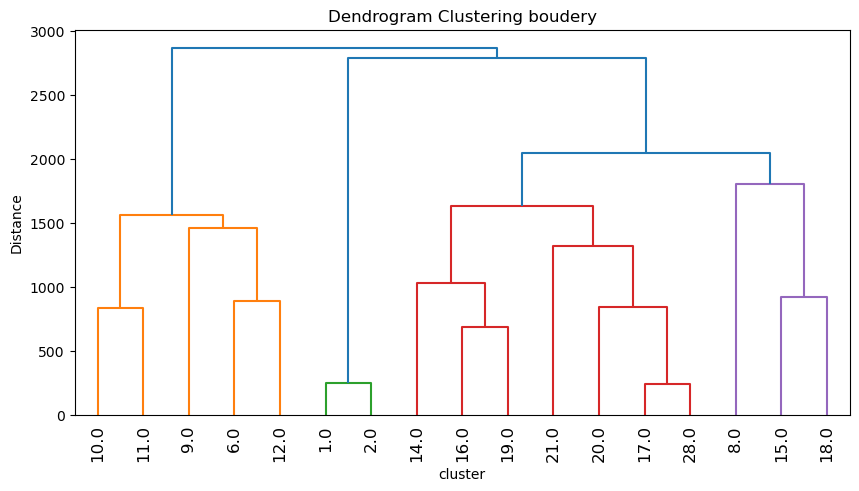

In [20]:
# Compute the linkage matrix using the average method
Z = linkage(D, method='average')

# Plot the dendrogram
fig, ax = plt.subplots(figsize=(10, 5))

dendrogram(Z,labels = embbeding_df['cluster'].values)

# Set axis labels
plt.title('Dendrogram Clustering boudery')
plt.xlabel('cluster')
plt.ylabel('Distance')

# Rotate x-axis labels
plt.xticks(rotation=90)

# Show the plot
plt.show()

In [21]:
# Cluster the data using the linkage matrix and the maximum distance threshold of 0.5
labels = fcluster(Z, t=1400, criterion='distance')

# Print the cluster labels for each point
print(labels)
print(embbeding_df['cluster'].values)

[4 4 2 8 3 1 1 2 5 7 5 6 7 5 6 6 6]
[ 1.  2.  6.  8.  9. 10. 11. 12. 14. 15. 16. 17. 18. 19. 20. 21. 28.]


In [22]:
new_cluster_dict = {'cluster':embbeding_df['cluster'].values
               ,'new_cluster':labels}
new_cluster_df = pd.DataFrame(new_cluster_dict)
new_cluster_df = cluster_df.merge(new_cluster_df, how = 'inner')

# Plot To Check Result

In [23]:
new_cluster_df

ltt         lgt  land_no  cluster  new_cluster
0     13.899888  100.705661   103583        1            4
1     13.900014  100.705649   103584        1            4
2     13.900149  100.705637   103585        1            4
3     13.900293  100.705624   103586        1            4
4     13.900427  100.705611   103587        1            4
...         ...         ...      ...      ...          ...
2531  13.895691  100.712677   107285       28            6
2532  13.895679  100.712547   107286       28            6
2533  13.897852  100.712447   107287       28            6
2534  13.898043  100.712510   107288       28            6
2535  13.895571  100.712295   107289       28            6

[2536 rows x 5 columns]

In [24]:
import folium
def get_google_sattelite_layer():
    '''This function return non-ovelay google satelite folium tilelayer 
    use to minimize creating tile layer code
    '''
    return folium.TileLayer(
            tiles = 'http://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
            attr = 'Google',
            name = 'Google Satellite',
            overlay = False,
            show = False)

In [25]:
#preview area
db_map = folium.Map(location = [lat,long] , zoom_start = 15, tile = 'openstreetmap')
get_google_sattelite_layer().add_to(db_map)
point_layer = folium.FeatureGroup(name = "Point" , overlay = True , show = False).add_to(db_map)
moo_ban_layer = folium.FeatureGroup(name = "Moo_ban" , overlay = True , show = False).add_to(db_map)
boudery_layer = folium.FeatureGroup(name = "Boudery Before Image" , overlay = True , show = False).add_to(db_map)
new_boudery_layer = folium.FeatureGroup(name = "Boudery After Image" , overlay = True , show = False).add_to(db_map)
folium.GeoJson(search_area).add_to(db_map)
folium.LayerControl().add_to(db_map)

In [26]:
for _,r in mooban_gdf_in_area.iterrows():
    
    iframe = folium.IFrame('<b>LAT</b>: ' + str(r['LAT'])
                            + '<br>' +'<b>LONG</b>: ' + str(r['LONG']) 
                            + '<br>' + '<b>ชื่อ</b>: ' + str(r['PRJ_NAMT']))

    popup = folium.Popup(iframe, min_width=300, max_width=300)
    
    folium.Marker(location = [r['LAT'],r['LONG']]
                 ,popup=popup).add_to(moo_ban_layer)

In [27]:
# Extract Polygon from each cluster

for new_cluster in np.unique(new_cluster_df['new_cluster'].values):
    
    focus_df = new_cluster_df[new_cluster_df['new_cluster'] == new_cluster]
    

    points = [[focus_df.iloc[i]['ltt'] ,
              focus_df.iloc[i]['lgt'],
              int(focus_df.iloc[i]['land_no'])] 
              for i in range(len(focus_df))]
    
    # convert the latitude and longitude points to Point objects
    geometry = [Point(xy) for xy in points]

    # create a GeoDataFrame with the points and labels
    gdf = gpd.GeoDataFrame({'geometry': geometry})

    # select only the points in the target cluster
    cluster_points = gdf['geometry'].tolist()

    # create a polygon around the cluster using the ConvexHull method
    polygon = Polygon([(p.x, p.y) for p in cluster_points]).convex_hull

    # create a GeoDataFrame with the polygon
    gdf = gpd.GeoDataFrame({'geometry': [polygon]})
    
    poly = gdf['geometry'].values[0]

    # extract the vertices from the polygon object
    vertices = list(poly.exterior.coords)

    # create a polygon object for folium
    folium_poly = folium.Polygon(locations=vertices,
                                 popup = folium.Popup(folium.IFrame('<b>CLUSTER</b>: ' + str(new_cluster))
                                                                    , min_width=100, max_width=100) ,
                                 color='red', 
                                 fill_color='red')

    # add the polygon to the map
    folium_poly.add_to(new_boudery_layer)

In [28]:
# add new cluster boudery
for cluster in np.unique(new_cluster_df['cluster'].values):
    
    focus_df = new_cluster_df[new_cluster_df['cluster'] == cluster]
    
    #random color because it may has many cluster
    
    color = ["#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])]
    
    for _,r in focus_df.iterrows():

        iframe = folium.IFrame('<b>LAT</b>: ' + str(r['lgt'])
                                + '<br>' +'<b>LONG</b>: ' + str(r['ltt']) 
                                + '<br>' + '<b>เลขโฉนด</b>: ' + str(r['land_no'])
                                + '<br>' + '<b>CLUSTER</b>: ' + str(r['cluster']))

        popup = folium.Popup(iframe, min_width=300, max_width=300)

        folium.Circle(location = [r['ltt'],r['lgt']]
                      ,color = color
                      ,fill_color = color
                      ,radius = 3
                     ,popup=popup).add_to(point_layer)
    poly = cluster_polygon_gdf[cluster_polygon_gdf['cluster'] == cluster]['geometry'].values[0]
    # extract the vertices from the polygon object
    vertices = list(poly.exterior.coords)

    # create a polygon object for folium
    folium_poly = folium.Polygon(locations=vertices,
                                 popup = folium.Popup(folium.IFrame('<b>CLUSTER</b>: ' + str(cluster))
                                                                    , min_width=100, max_width=100) ,
                                 color='red', 
                                 fill_color='red')
    # add the polygon to the map
    folium_poly.add_to(boudery_layer)

In [29]:
db_map

In [30]:
# similarity = cosine_similarity(embedding_output['embbeding_vector'][12].reshape(1, -1), embedding_output['embbeding_vector'][16].reshape(1, -1))
# print(f"The similarity score between the two images is: {similarity[0][0]}")
db_map.save('village_red_box.html')